# Netzwerk aus Dokumenten aufgrund ihrer Ähnlichkeit

- Wir probieren nun was ganz anderes. Nämlich ein Netzwerk aus Dokumenten zu bauen aufgrund ihrer Ähnlichkeit zueinander. 
- Die Idee dahinter ist Dokumente visuell zu clustern und so zu erkennnen welche ähnlichen Dokumente zusammengehören. 
- Die Idee ähnliche Dinge als Netzwerk zu visualisieren ist sehr praktisch und mächtig weil sie uns erlaubt in allen Dingen Muster zu sehen. 
- Wir probieren das mal anhand der Berichterstattung auf der Fronpage von swissinfo. 

# Artikel von der Front Page scrapen
- Zuerst scrapen wir die Artikel von der Frontpage

In [1]:
import requests
from bs4 import BeautifulSoup
import nltk

/Users/edzardschade/.virtualenvs/erstesVE/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Get 100 Frontpage Items
frontpage_url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/overview"
r = requests.get(frontpage_url).json()
items = []
urls = []
for item in r["page"]["item"][0]["content"]:
    try:
        tmp = requests.get("https://www.swissinfo.ch/webservice/swi-eng-2.0/detail%s" % item["url"])
        text = BeautifulSoup(tmp.json()["htmldetail"], "lxml").get_text()
        items.append(text)
        urls.append(item["canonical"])
        print("Done: %s" % item["url"])
    except:
        pass

Done: /webservice/swi-eng-2.0/detail/42579872/44560650
Done: /webservice/swi-eng-2.0/detail/42579872/44623996
Done: /webservice/swi-eng-2.0/detail/42579872/44623032
Done: /webservice/swi-eng-2.0/detail/42579872/44618048
Done: /webservice/swi-eng-2.0/detail/42579872/44618150
Done: /webservice/swi-eng-2.0/gallery/42579876/44619378
Done: /webservice/swi-eng-2.0/detail/42579872/44616080
Done: /webservice/swi-eng-2.0/detail/42579872/44617654
Done: /webservice/swi-eng-2.0/detail/42579872/44617816
Done: /webservice/swi-eng-2.0/detail/42579872/44615866
Done: /webservice/swi-eng-2.0/detail/42579872/44615656
Done: /webservice/swi-eng-2.0/detail/42579872/44613728
Done: /webservice/swi-eng-2.0/detail/42579872/44616450
Done: /webservice/swi-eng-2.0/detail/42579872/44612456
Done: /webservice/swi-eng-2.0/detail/42579872/44613232
Done: /webservice/swi-eng-2.0/detail/42579872/44574850
Done: /webservice/swi-eng-2.0/detail/42579872/44609546
Done: /webservice/swi-eng-2.0/detail/42579872/44609428
Done: /we

In [3]:
items[1][0:300]

'    COP24: Text adopted, ambitions abandoned - SWI swissinfo.ch             The President of\xa0COP24, Michal Kurtyka of Poland, officially concluded the summit on Saturday.(Keystone)       Representatives of 190 countries attending the COP24 climate summit in Katowice accepted the rules for implementi'

In [4]:
urls[1]

'https://www.swissinfo.ch/eng/politics/opinion_cop24--text-adopted--ambitions-abandoned/44623996'

# Dokumentenähnlichkeit bestimmen
- Work tokenization: Aufspalten
- Stemming: Auf Wortstämme zurückführen
- Stopword removal: Füllwörter rausnehmen
- (Clustering with k-means)

In [5]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import seaborn as sns

def word_tokenizer(text):
        #tokenizes and stems the text
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens


def cluster_items(items, nb_of_clusters=5,mds=False):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        lowercase=True)
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(items)
        
        # Show matrix
        pairwise_similarity = tfidf_matrix * tfidf_matrix.T
        ax = sns.heatmap(pairwise_similarity.A)
        ax.plot()
        
        # Clustering
        kmeans = KMeans(n_clusters=nb_of_clusters)
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        if mds:
            return [pairwise_similarity,dict(clusters)]
        else:
            return dict(clusters)


#items = ["Nature is beautiful","I like green apples", "We should protect the trees","Fruit trees provide fruits","Green apples are tasty"]

#nclusters= 3
#parwise_similarity, clusters = cluster_items(items, nclusters,True)

# Baby example: Wie funktioniert das nochmal?

Wie sieht das Resultat aus für:
- 2 Sätze mit nature
- 2 Sätze mit apple
- 1 Satz mit apple and nature
- 1 Satz mit computers

/Users/edzardschade/.virtualenvs/erstesVE/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  sorted(inconsistent))


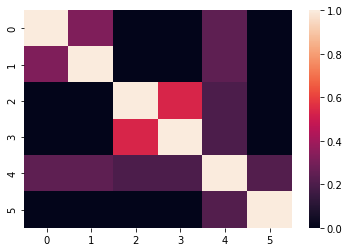

In [6]:
nclusters = 3
baby_items = ["Nature is beautiful",
              "We should protect nature",
              "I like green apples", 
              "Green apples are tasty",
              "Apples and nature are fun.",
              "Technical sentence with computers."]
result,clusters = cluster_items(baby_items,nclusters,True)

In [7]:
clusters

{2: [0, 1], 0: [2, 3], 1: [4, 5]}

In [10]:
for cluster in range(nclusters):
        print ("cluster ",cluster,":")
        for i,item in enumerate(clusters[cluster]):
                print ("\titem ",i,": ",baby_items[item])

cluster  0 :
	item  0 :  I like green apples
	item  1 :  Green apples are tasty
cluster  1 :
	item  0 :  Apples and nature are fun.
	item  1 :  Technical sentence with computers.
cluster  2 :
	item  0 :  Nature is beautiful
	item  1 :  We should protect nature


## Jetzt die Ähnlichkeit der Artikel auf der Frontpage bestimmen

/Users/edzardschade/.virtualenvs/erstesVE/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  sorted(inconsistent))


cluster  0 :
	url  sci-tech :  publish-or-perish_how-scientists-are-redefining-success
	url  politics :  opinion_cop24--text-adopted--ambitions-abandoned
	url  business :  reinsurance-model_novartis-weighs-reinsurance-tie-up-to-fund-ultra-expensive-drugs
	url  society :  -weareswissabroad---fran%C3%A7ois-schwalb_-being-swiss-is-an-essential-part-of-my-identity-
	url  society :  week-in-numbers_transport--terrorism--and-dual-nationals
	url  multimedia :  photography_switzerland-after-sundown
	url  politics :  un-migration-pact_where-swiss-development-aid-meets-migration
	url  business :  dlt-report_switzerland-sets-legal-foundations-for-blockchain-industry
	url  society :  new-drugs_do-we-need-clinics-for-internet-and-sex-addicts-
	url  eng :  international-law_tale-of-swiss-based-syrian-torture-survivor-highlights-dublin-flaws
	url  business :  underrepresented-women_men-appointed-to-boards-because-it-s--easier-
	url  business :  inside-geneva_what-now-for-syria-
	url  society :  ten-a

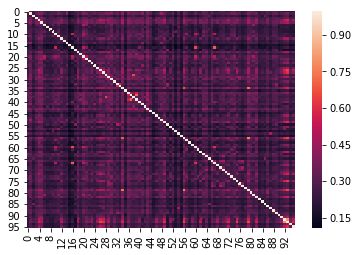

In [11]:
result,clusters = cluster_items(items,nclusters,True)
for cluster in range(nclusters):
        print ("cluster ",cluster,":")
        for i,item in enumerate(clusters[cluster]):
                print ("\turl ",urls[i].split("/")[-3],": ",urls[i].split("/")[-2])

# Als Netzwerk exportieren

In [12]:
urls[0]

'https://www.swissinfo.ch/eng/sci-tech/publish-or-perish_how-scientists-are-redefining-success/44560650'

In [13]:
import networkx as nx
G  = nx.Graph(name="Texts")

for url in urls:
    url_clean = url.split("/")[-2]
    G.add_node(url, size=1, label=url)

entries = result.todense().tolist()

for i,row in enumerate(urls):
    row = row.split("/")[-2]
    for j,col in enumerate(urls):
        col = col.split("/")[-2]
        if entries[i][j] > 0.2:
            G.add_edge(row,col,weight=entries[i][j])

nx.write_gexf(G,"Texts.gexf")